In [11]:
import os
from dotenv import load_dotenv

load_dotenv() 

mysql_host = os.getenv("MYSQL_HOST")
mysql_user = os.getenv("MYSQL_USER")
mysql_password = os.getenv("MYSQL_PASSWORD")
mysql_database = os.getenv("MYSQL_DATABASE")

In [3]:
import mysql.connector

conn = mysql.connector.connect(
    host=mysql_host,
    user=mysql_user,
    password=mysql_password,
    database=mysql_database
)

print("Connected successfully!")

Connected successfully!


In [4]:
cursor = conn.cursor()

# Create the unemployment table
cursor.execute("""
    CREATE TABLE IF NOT EXISTS unemployment (
        id INT AUTO_INCREMENT PRIMARY KEY,
        report_date DATE,
        unemployment_rate FLOAT
    )
""")

print("Table created successfully.")

Table created successfully.


In [5]:
import pandas as pd

df = pd.read_csv('UNRATE.csv')
df.columns = ['report_date', 'unemployment_rate']
df['report_date'] = pd.to_datetime(df['report_date'])

for _, row in df.iterrows():
    cursor.execute("""
        INSERT INTO unemployment (report_date, unemployment_rate)
        VALUES (%s, %s)
    """, (row['report_date'].date(), row['unemployment_rate']))
    
conn.commit()
print("Data inserted successfully.")

Data inserted successfully.


In [6]:
import matplotlib.pyplot as plt
query = "SELECT report_date, unemployment_rate FROM unemployment ORDER BY report_date"
df = pd.read_sql(query, conn)

df['report_date'] = pd.to_datetime(df['report_date'])

/var/folders/4x/vc4n3hks6x52rw68mr4svpdh0000gn/T/ipykernel_80172/2743117542.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


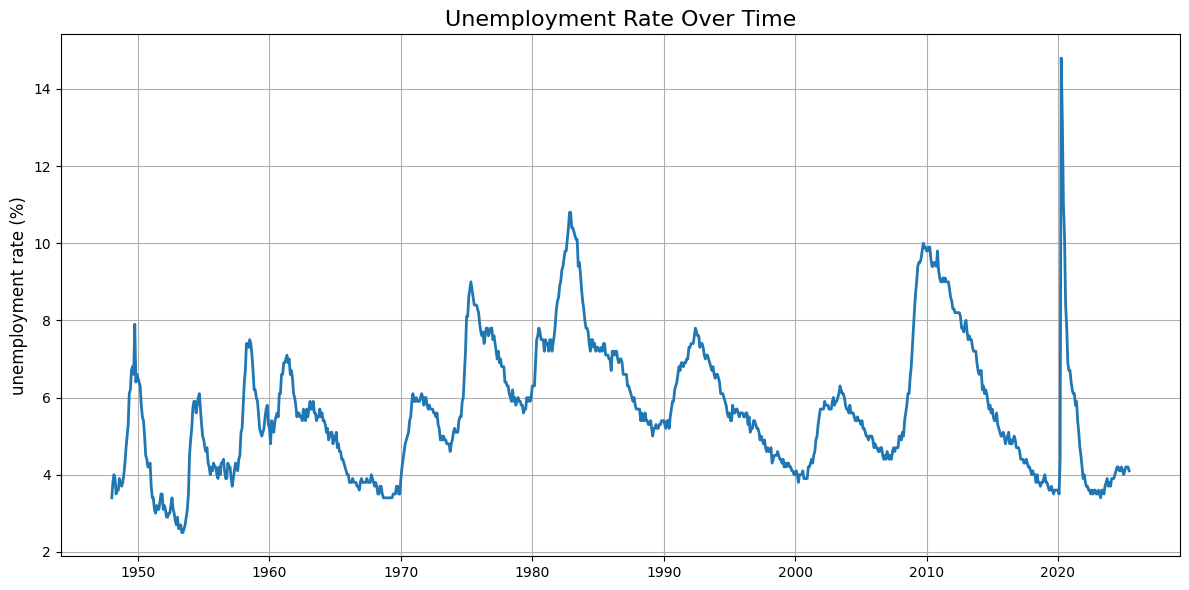

In [7]:
plt.figure(figsize=(12, 6))
plt.plot(df['report_date'], df['unemployment_rate'], linewidth=2)
plt.title('Unemployment Rate Over Time', fontsize=16)
plt.ylabel('unemployment rate (%)', fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()

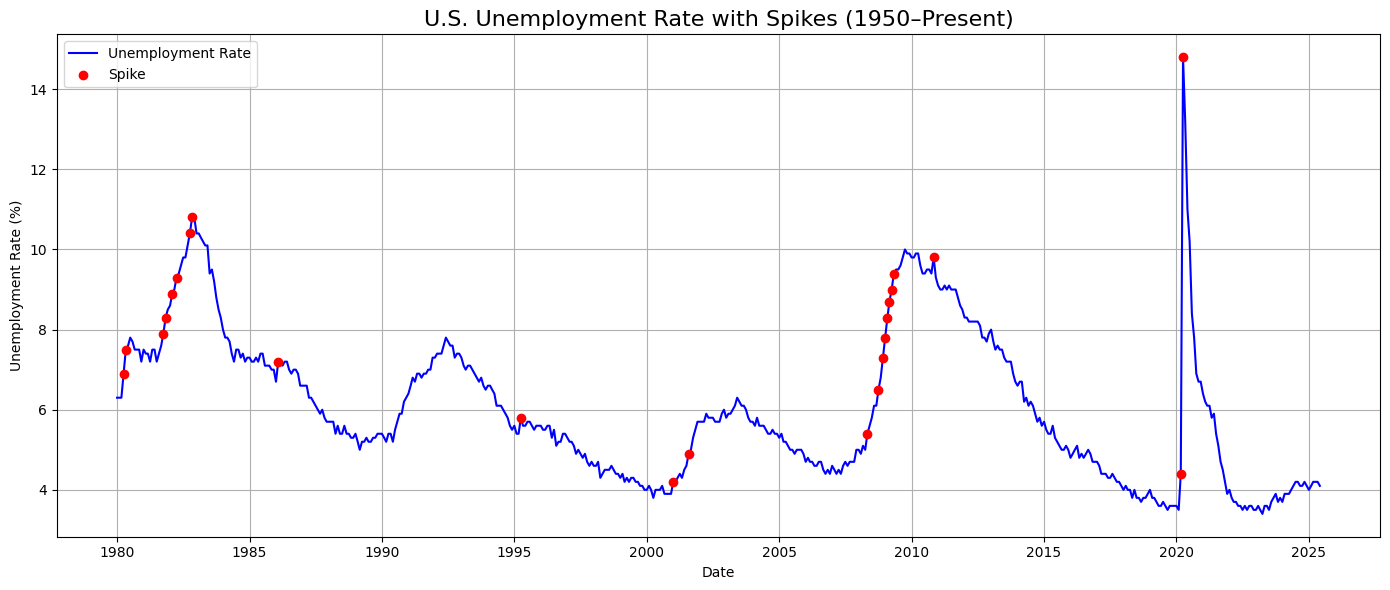

In [12]:
df = df[df['report_date'].dt.year >= 1980].reset_index(drop=True)

df['change'] = df['unemployment_rate'].diff()

threshold = 0.3
df['is_spike'] = df['change'] >= threshold

spikes = df[df['is_spike']]

plt.figure(figsize=(14, 6))
plt.plot(df['report_date'], df['unemployment_rate'], label='Unemployment Rate', color='blue')
plt.scatter(spikes['report_date'], spikes['unemployment_rate'], color='red', label='Spike', zorder=5)

plt.title("U.S. Unemployment Rate with Spikes (1950–Present)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [9]:
top_spikes = df.sort_values(by='change', ascending=False).head(5)
print(top_spikes[['report_date', 'unemployment_rate', 'change']])

     report_date  unemployment_rate  change
1449  2020-04-01               14.8    10.4
1446  2020-03-01                4.4     0.9
9     1980-04-01                6.9     0.6
12    1980-05-01                7.5     0.6
1047  2009-02-01                8.3     0.5


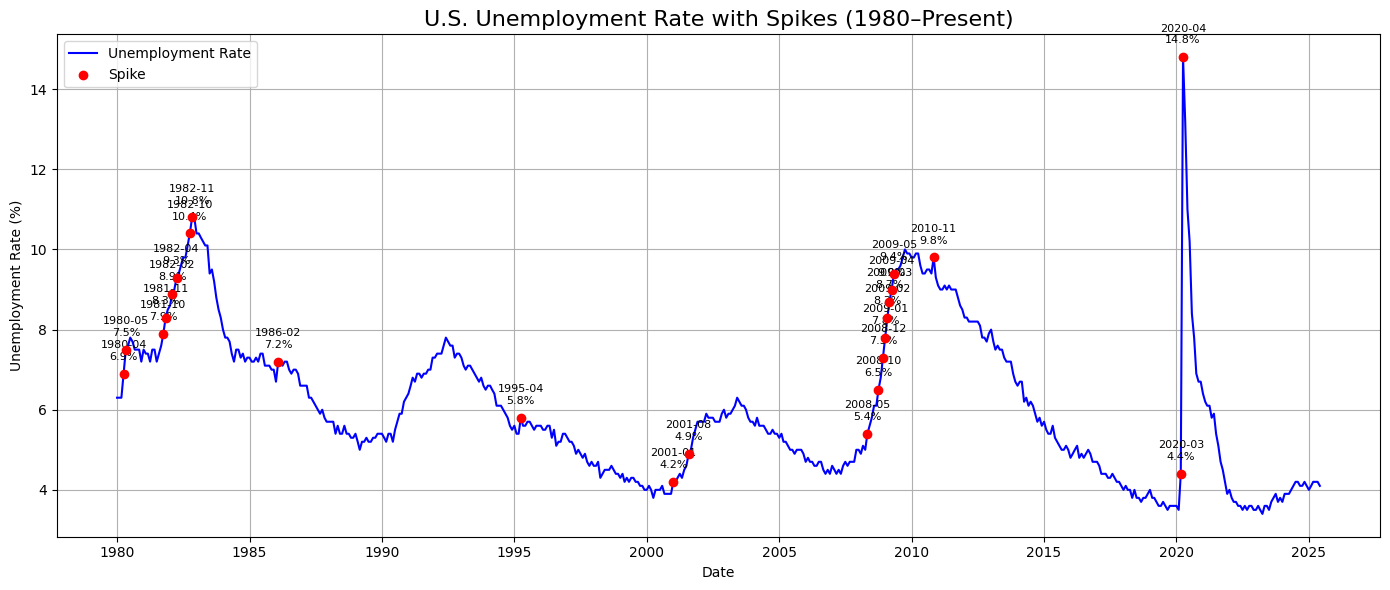

In [13]:
plt.figure(figsize=(14, 6))
plt.plot(df['report_date'], df['unemployment_rate'], label='Unemployment Rate', color='blue')
plt.scatter(spikes['report_date'], spikes['unemployment_rate'], color='red', label='Spike', zorder=5)

for i, row in spikes.iterrows():
    plt.annotate(
        f"{row['report_date'].strftime('%Y-%m')}\n{row['unemployment_rate']}%",
        (row['report_date'], row['unemployment_rate']),
        textcoords="offset points",
        xytext=(0,10),
        ha='center',
        fontsize=8
    )

plt.title("U.S. Unemployment Rate with Spikes (1980–Present)", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Unemployment Rate (%)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()